In [1]:
import json

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch, Circle, Arc
from matplotlib.lines import Line2D
import seaborn as sns
import numpy as np

In [43]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)

animals_used = [1091, 1093, 1060, 1062, 1074, 1092, 1102, 1076, 1082, 1101]
diabetic =     [1076, 1082, 1101]
impaired =     [1060, 1062, 1074, 1092, 1102]
normal =       [1091, 1093]
animal_tol = {
    1076: 'diabetic', 1082: 'diabetic', 1101: 'diabetic', 1060: 'impaired', 1062: 'impaired', 
    1074: 'impaired', 1092: 'impaired', 1102: 'impaired', 1091: 'normal', 1093: 'normal'}
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# Use data that was sent to collaborators 
data = pd.read_excel(r'../data/processed/combined_metabolites_data.xlsx').set_index('i')
data_cols = data.filter(regex='FBG|RBG').columns
fbg_cols = data.filter(regex='FBG').columns
rbg_cols = data.filter(regex='RBG').columns
pval_cols = data.filter(regex='pval').columns

n = data.filter(regex='1091|1093')                 # normal
i = data.filter(regex='1060|1062|1074|1092|1102')  # impaired
d = data.filter(regex='1076|1082|1101')            # diabetic

f = data[fbg_cols]  # fasted
r = data[rbg_cols]  # random-fed

fn = n.filter(fbg_cols)  # fasted normal 
fi = i.filter(fbg_cols)  # fasted impaired
fd = d.filter(fbg_cols)  # fasted diabetic

rn = n.filter(rbg_cols)  # random normal
ri = i.filter(rbg_cols)  # random impaired
rd = d.filter(rbg_cols)  # random diabetic

qval_sampling = data['fdr corrected pval effect of sampling']
qval_gtol = data['fdr corrected pval effect of glucose tolerance']
qval_cross = data['fdr corrected pval effect of interaction sampling and glucose tolerance']

In [2]:
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile)
with open(r'..\data\metadata\extra color maps\metab_lipid_class_superclass_color.json', 'r') as infile:
    class_map = json.load(infile)

In [3]:
c31 = pd.read_csv(r'../data/search/CD31/peak_finder/Final_Results_CD31.csv').drop('Unnamed: 74', axis=1)
c33 = pd.read_csv(r'../data/search/CD33/peak_finder/Final_Results_CD33.csv').drop('Unnamed: 74', axis=1)
c3f = pd.read_csv(r'../data/search/CD33/peak_finder/Final_Results_CD33_filter.csv').drop('Unnamed: 74', axis=1)
# c3f = data which is same as c33, except it underwent filtering using only CD 3.3 filtering functions

c31['Lipid Class'] = c31['Lipid Class'].replace(np.nan, 'unknown')
c33['Lipid Class'] = c33['Lipid Class'].replace(np.nan, 'unknown')
c3f['Lipid Class'] = c3f['Lipid Class'].replace(np.nan, 'unknown')

qc_cols = ['20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11)',
           '20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC3.raw (F13)']
data_cols = c31.filter(regex='_RBG|_FBG').drop(qc_cols, axis=1).columns
blank_cols = c31.filter(regex='Blank|Water').columns
qc_cols = c31.filter(regex='QC').columns

### Create df with log2 values and summary stats

In [4]:
def make_df(indf):
    df = indf.loc[:, indf.filter(regex=' \(F').columns]
    df['blankratio'] = df[data_cols].mean(axis=1) / df[blank_cols].max(axis=1)
    df = np.log2(df)
    df['mean'] = df[data_cols].mean(axis=1)
    df['std'] = df[data_cols].std(axis=1)
    df['rsd'] = df['std'] / df['mean']
    df['blankmax'] = df[blank_cols].max(axis=1)
#     df['blankratio'] = df['mean'] / df['blankmax']
    return df

c31d = make_df(c31)
c33d = make_df(c33)
c3fd = make_df(c3f)

### Num. features, num. IDs, ID/feature ratio

In [18]:
numfeats31 = len(c31)
numfeats33 = len(c33)
numfeats3f = len(c3f)
numid31 = len(c31.loc[c31['Identification'].notna()])
numid33 = len(c33.loc[c33['Identification'].notna()])
numid3f = len(c3f.loc[c3f['Identification'].notna()])
ratio31 = numid31 / numfeats31
ratio33 = numid33 / numfeats33
ratio3f = numid3f / numfeats3f

print('Number of LipiDex Features: ', numfeats31, numfeats33, numfeats3f, '\n')
print('Number of LipiDex IDs: ', numid31, numid33, numid3f, '\n')
print('Percent of features identified: ', round(ratio31*100, 1), 
      round(ratio33*100, 1),  round(ratio3f*100, 1), '\n')
print('Number of starting features from CD 3.3 output:')
print('CD 3.1 without CD filtering: ', 'dont remember, maybe 3500? It was about 5000 originally, '
      'but blank filter got a lot')
print('CD 3.3 without CD filtering: ', 10521)
print('CD 3.3 including CD filtering: ', 2468)

Number of LipiDex Features:  1487 3552 1492 

Number of LipiDex IDs:  344 493 391 

Percent of features identified:  23.1 13.9 26.2 

Number of starting features from CD 3.3 output:
CD 3.1 without CD filtering:  dont remember, maybe 3500? It was about 5000 originally, but blank filter got a lot
CD 3.3 without CD filtering:  10521
CD 3.3 including CD filtering:  2468


### Lipid Classes and counts

In [19]:
print(c31['Lipid Class'].dropna().unique())
print(c33['Lipid Class'].dropna().unique())
print(c3f['Lipid Class'].dropna().unique())
print('\nCD31 and CD33 have identical lipid classes represented')

# print(c31['Lipid Class'].value_counts())
# print(c33['Lipid Class'].value_counts())

val_counts = pd.concat([c31['Lipid Class'].value_counts(), 
                        c33['Lipid Class'].value_counts(),
                        c3f['Lipid Class'].value_counts()], axis=1)
val_counts.columns = ['CD31', 'CD33', 'CD33f']
val_counts#.to_clipboard()

['unknown' 'LysoPI' 'AC' 'LysoPC' 'LysoPE' 'PC' 'Alkenyl-DG' 'PI' 'SM'
 'Plasmenyl-PC' 'Plasmanyl-PC' 'Plasmenyl-PE' 'PE' 'Plasmanyl-PE'
 'Cer[NS]' 'TG' 'CE']
['unknown' 'LysoPI' 'AC' 'LysoPC' 'LysoPE' 'PC' 'PI' 'Alkenyl-DG' 'SM'
 'Plasmenyl-PC' 'Plasmanyl-PC' 'PE' 'Plasmenyl-PE' 'Plasmanyl-PE'
 'Cer[NS]' 'TG' 'CE']
['unknown' 'LysoPI' 'AC' 'LysoPC' 'LysoPE' 'PC' 'PI' 'Alkenyl-DG' 'SM'
 'Plasmenyl-PC' 'Plasmanyl-PC' 'Plasmenyl-PE' 'PE' 'Plasmanyl-PE'
 'Cer[NS]' 'TG' 'CE']

CD31 and CD33 have identical lipid classes represented


,CD31,CD33,CD33f
unknown,1143,3059,1101
TG,117,143,129
PC,67,137,74
Plasmanyl-PC,30,38,36
SM,26,48,39
LysoPC,22,30,24
Plasmenyl-PE,18,18,18
PI,15,16,16
Plasmenyl-PC,12,12,12
Plasmanyl-PE,12,13,13


### RT/MZ plots

In [20]:
custom_handles, custom_labels = [], []
for superclass, color in list(colors.items())[7:12] + [('Unidentified', colors['Unidentified'])]:
    print(superclass, color)
    custom_handles.append(Line2D([0], [0], marker='o', color=color, markersize=10, linewidth=0))
    custom_labels.append(superclass)

Glycerolipid [0.5803921568627451, 0.403921568627451, 0.7411764705882353]
Fatty Acyl [0.8392156862745098, 0.15294117647058825, 0.1568627450980392]
Sterol Lipid [0.12156862745098039, 0.4666666666666667, 0.7058823529411765]
Sphingolipid [1.0, 0.4980392156862745, 0.054901960784313725]
Phospholipid [0.17254901960784313, 0.6274509803921569, 0.17254901960784313]
Unidentified [0.4980392156862745, 0.4980392156862745, 0.4980392156862745]


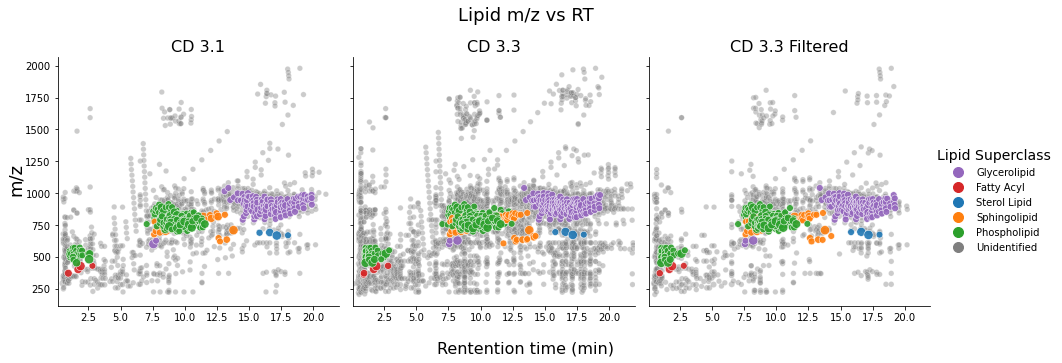

In [41]:
# Plot Lipids 
def plot_mzrt(df, ax, title, **kwargs):
    for lipid_class in unique_lipid_classes:
        if lipid_class == 'LysoPI':
            continue
        sns.scatterplot(
            x='Retention Time (min)', y='Quant Ion',          
            data=df.loc[df['Lipid Class'] == lipid_class],   
            size='Area (max)',   
            sizes=((45, 85) if lipid_class != 'unknown' else (30, 60)), 
            alpha=(0.9 if lipid_class != 'unknown' else 0.4),  
            color=class_map[lipid_class][0],         
            edgecolors='black',
            label=lipid_class,
            ax=ax,
            legend=False,
    )
    ax.set_title(f'{title}', fontsize=16)
#     ax.legend([None])
    ax.set_xlabel('')
    ax.set_ylabel('')
    sns.despine()

fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharey=True, sharex=True)
fig.set_size_inches((15,5))
unique_lipid_classes = c31['Lipid Class'].unique()
    
for df, ax, title in [(c31, ax1, 'CD 3.1'), (c33, ax2, 'CD 3.3'), (c3f, ax3, 'CD 3.3 Filtered')]:
    plot_mzrt(df, ax, title)
plt.xlim(0.1, 22)
fig.suptitle('Lipid m/z vs RT', fontsize=18)
fig.supxlabel('Rentention time (min)', fontsize=16)
fig.supylabel('m/z', fontsize=18)
plt.legend(custom_handles, custom_labels, loc=(1.01, 0.2), frameon=False, 
               title='Lipid Superclass', title_fontsize=14)
plt.tight_layout()
# plt.savefig(r'..\reports\figures\1-0-1\CD33_vs_CD31_vs_CD33f_lipids_mz_rt.svg', bbox_inches='tight')
# plt.savefig(r'..\reports\figures\1-0-1\CD33_vs_CD31_vs_CD33f_lipids_mz_rt.png', bbox_inches='tight', dpi=300)

### Run search of all 3.1 features against all 3.3 features using m/z and RT to find the overlap

### Compare quants in 3.1 vs 3.3

In [538]:
fa = '18:2_20:1'
fa = [x.split(':') for x in fa.split('_')]

C = sum([int(chain[0]) for chain in fa])
unsat = sum([int(chain[1]) for chain in fa])
unsat
fa

[['18', '2'], ['20', '1']]

In [22]:
def parse_lipid(lipid):
    l = lipid.split(' ')
    cls = l[0]
    fa = l[1]
    
    if '-' in fa:
        fa = fa.split('-')[1]
        label = fa.split('-')[0] + '-'
    else:
        label = ''
    if 'd' in fa:
        fa = fa.split('d')[1]
        label = fa.split('d')[0] + 'd'
    else:
        label = ''
        
    fa = [x.split(':') for x in fa.split('_')]
    fa = [[int(x) for x in sublist] for sublist in fa]
    carbons = sum([chain[0] for chain in fa])
    unsat = sum([chain[1] for chain in fa])
    result = cls + ' ' + label + str(carbons) + ':' + str(unsat)
#     print(lipid, result)
    return cls, label, carbons, unsat, fa

def ppm_tol(mz1, mz2):
    if 1e6 * abs(mz1 - mz2) / mz1 < 1:
        return True
    else:
        return False

def rt_tol(rt1, rt2):
    if abs(rt1 - rt2) < 0.15:
        return True
    else:
        return False

def id_match(i1, i2):
    if pd.isna(c31.loc[i1, 'Identification']):
        return True
    elif c31.loc[i1, 'Identification'] == c33.loc[i2, 'Identification']:
        return True
    elif pd.notna(c33.loc[i2, 'Identification']) and \
        parse_lipid(c31.loc[i1, 'Identification']) == parse_lipid(c33.loc[i2, 'Identification']):
        return True
    else:
        print(i1, c31.loc[i1, 'Identification'], 'and',
              i2, c33.loc[i2, 'Identification'], 'did not match', )
        return False

In [24]:
c31mzrt = dict((x, [y, z]) for x, y, z in zip(c31.index, c31['Quant Ion'], c31['Retention Time (min)']))
c33mzrt = dict((x, [y, z]) for x, y, z in zip(c33.index, c33['Quant Ion'], c33['Retention Time (min)']))
c3fmzrt = dict((x, [y, z]) for x, y, z in zip(c3f.index, c3f['Quant Ion'], c3f['Retention Time (min)']))
matches = []
quant_diffs = []

for i1, (mz1, rt1) in c31mzrt.items():
    for i3, (mz3, rt3) in c33mzrt.items():
        if ppm_tol(mz1, mz3) and rt_tol(rt1, rt3):
            match = sorted((i1, i3))
            if match not in matches:
                quant_diffs.append(c31d.loc[i1, 'mean'] - c33d.loc[i3, 'mean'])
                matches.append(match)
                id_match(i1, i3)
print('\nNumber of matched features: ', len(matches))
print('Proportion of CD 3.1 features with match: ', len(matches) / len(c31) * 100)
matches = pd.DataFrame(matches, columns=['CD31_i', 'CD33_i'])
matches['quant_31_minus_33'] = quant_diffs
# The indexes of unmatched features in CD31 dataframe
unmatched_feats = list(set(sorted(matches['CD31_i'].unique())).symmetric_difference(set(range(1487))))
print(len(unmatched_feats))

413 Alkenyl-DG P-38:6 and 976 nan did not match
415 PC 38:7 and 947 PC 18:2_20:5 did not match
457 PC 18:2_20:4 and 1080 PC 38:6 did not match
509 PC 18:1_22:6 and 1184 PC 40:7 did not match
582 Plasmenyl-PE P-38:6 and 1357 Plasmenyl-PE P-16:0_22:6 did not match
587 PC 18:2_18:1 and 1410 PC 36:3 did not match
614 PC 36:3 and 1360 PC 18:2_18:1 did not match
756 Plasmanyl-PE O-18:0_22:6 and 1738 nan did not match
768 Plasmanyl-PC O-16:0_16:0 and 1740 Plasmanyl-PC O-32:0 did not match
803 PC 36:3 and 1792 nan did not match
864 Plasmanyl-PC O-36:1 and 1929 Plasmanyl-PC O-18:0_18:1 did not match
869 Plasmanyl-PC O-38:2 and 1950 Plasmanyl-PC O-20:0_18:2 did not match
1039 TG 18:2_20:5_20:4 and 2405 TG 58:11 did not match
1074 TG 18:1_20:5_22:6 and 2452 TG 60:12 did not match
1091 TG 18:2_18:2_22:6 and 2507 TG 58:10 did not match
1124 TG 58:10 and 2585 TG 16:0_20:4_22:6 did not match
1148 TG 48:3 and 2643 nan did not match
1188 TG 17:0_18:2_22:6 and 2741 TG 57:8 did not match
1203 TG 60:10 an

In [530]:
print('The number of IDs missed by CD 3.3 is given by the number of "did not match" lines printed out above')

The number of IDs missed by CD 3.3 is given by the number of "did not match" printed out above


In [28]:
matches = []
quant_diffs = []

for i1, (mz1, rt1) in c31mzrt.items():
    for i3, (mz3, rt3) in c3fmzrt.items():
        if ppm_tol(mz1, mz3) and rt_tol(rt1, rt3):
            match = sorted((i1, i3))
            if match not in matches:
                quant_diffs.append(c31d.loc[i1, 'mean'] - c3fd.loc[i3, 'mean'])
                matches.append(match)
                id_match(i1, i3)
print('\nNumber of matched features: ', len(matches))
print('Proportion of CD 3.1 features with match: ', len(matches) / len(c31) * 100)
matches = pd.DataFrame(matches, columns=['CD31_i', 'CD33_filtered_i'])
matches['quant_31_minus_33_filtered'] = quant_diffs
# The indexes of unmatched features in CD31 dataframe
unmatched_feats_31_33f = list(set(sorted(matches['CD31_i'].unique())).symmetric_difference(set(range(1487))))
print(len(unmatched_feats))

79 LysoPI 20:4 and 89 nan did not match
88 AC 14:1 and 99 nan did not match
92 LysoPC 20:5 and 110 nan did not match
95 LysoPC 16:0 and 132 nan did not match
96 LysoPC 18:2 and 122 nan did not match
106 LysoPC 22:6 and 140 nan did not match
107 LysoPE 20:4 and 143 nan did not match
108 LysoPC 15:0 and 144 nan did not match
109 LysoPC 20:4 and 145 nan did not match
110 LysoPE 18:2 and 146 nan did not match
112 LysoPC 18:2 and 147 nan did not match
123 LysoPC 16:0 and 167 nan did not match
131 LysoPE 16:0 and 165 nan did not match
134 LysoPC 16:0 and 167 nan did not match
141 LysoPC 18:1 and 181 nan did not match
143 AC 16:0 and 176 nan did not match
146 LysoPC 18:1 and 181 nan did not match
150 LysoPC 22:4 and 186 nan did not match
152 LysoPC 20:2 and 191 nan did not match
154 AC 18:1 and 189 nan did not match
155 LysoPC 17:0 and 193 nan did not match
158 LysoPC 20:2 and 191 nan did not match
160 LysoPC 17:0 and 193 nan did not match
172 LysoPC 18:0 and 201 nan did not match
172 LysoPC 

1065 TG 56:9 and 1085 nan did not match
1074 TG 18:1_20:5_22:6 and 1080 PC 38:6 did not match
1074 TG 18:1_20:5_22:6 and 1090 nan did not match
1077 TG 58:11 and 1093 nan did not match
1081 TG 14:0_18:2_22:6 and 1097 nan did not match
1082 TG 14:0_18:3_18:2 and 1099 nan did not match
1086 TG 56:9 and 1120 nan did not match
1091 TG 18:2_18:2_22:6 and 1106 Alkenyl-DG P-18:0_20:5 did not match
1094 TG 54:7 and 1108 nan did not match
1097 TG 18:1_22:6_22:6 and 1111 nan did not match
1101 TG 16:0_22:6_22:6 and 1116 nan did not match
1108 TG 52:6 and 1129 nan did not match
1112 TG 55:8 and 1130 nan did not match
1115 TG 18:2_18:2_22:5 and 1133 nan did not match
1116 TG 51:5 and 1134 nan did not match
1124 TG 58:10 and 1145 nan did not match
1127 TG 56:8 and 1146 Plasmanyl-PC O-36:5 did not match
1131 TG 54:7 and 1148 nan did not match
1136 TG 46:2 and 1155 nan did not match
1137 TG 48:3 and 1154 nan did not match
1143 TG 50:4 and 1158 nan did not match
1147 TG 54:6 and 1164 PC 16:0_22:6 did 

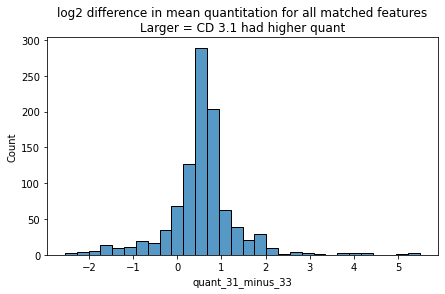

In [638]:
sns.histplot(matches['quant_31_minus_33'], bins=30)
plt.title('log2 difference in mean quantitation for all matched features\n'
          'Larger = CD 3.1 had higher quant', fontsize=12)
plt.gcf().set_size_inches(7, 4)
plt.savefig(r'..\reports\figures\1-0-1\quant_diff.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\1-0-1\quant_diff.png', bbox_inches='tight', dpi=300)

### What proportion of IDs in CD31 were found in CD33?

In [419]:
cd31_id_indexes = c31.loc[c31['Identification'].notna()].index
print('Number of IDs in CD 3.1: ', len(set(cd31_id_indexes)))
print('Number of IDs in CD 3.3: ', len(c33.loc[c33['Identification'].notna()]))
# print('All indexes in CD 3.1 found match in CD 3.3 =', len(set(cd31_id_indexes)) == len(set()))
matched_ids = matches.loc[matches['CD31_i'].isin(cd31_id_indexes), ['CD31_i', 'CD33_i']]
num_matched_ids = len(set(matched_ids['CD31_i']))
print(num_matched_ids)

Number of IDs in CD 3.1:  344
Number of IDs in CD 3.3:  493
283


In [418]:
matched_ids

,CD31_i,CD33_i
41,79,225
52,88,252
55,92,280
59,95,325
60,95,353
...,...,...
1185,1446,3421
1186,1447,3425
1187,1449,3435
1189,1451,3408


In [430]:
c31_matched_ids = c31.loc[matched_ids['CD31_i'], 'Identification'].reset_index()
c33_matched_ids = c33.loc[matched_ids['CD33_i'], 'Identification'].reset_index()
c33_matched_ids
(c31_matched_ids == c33_matched_ids)['Identification'].sum()

306

### Distribution of features that didn't find a match between CD 3.1 and either 3.3 unfiltered or filtered 

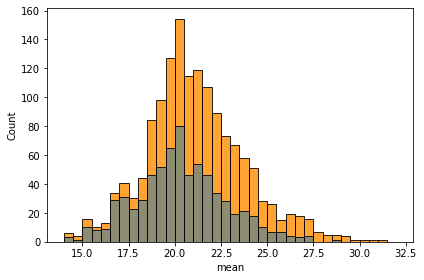

In [39]:
sns.histplot(c31d['mean'], color='darkorange', alpha=0.8, binrange=(14, 32), binwidth=0.5, label='')
sns.histplot(c31d.loc[unmatched_feats_31_33f, 'mean'], alpha=0.5, binrange=(14, 32), binwidth=0.5)

plt.tight_layout()
# plt.savefig(r'..\reports\figures\1-0-1\quant_distrib.svg', bbox_inches='tight')
# plt.savefig(r'..\reports\figures\1-0-1\quant_distrib.png', bbox_inches='tight', dpi=300)

In [38]:
c31mzrt

{0: [679.05463, 0.536],
 1: [641.1087, 0.537],
 2: [951.15973, 0.541],
 3: [329.03067, 0.542],
 4: [969.13147, 0.544],
 5: [623.13641, 0.546],
 6: [291.08359, 0.551],
 7: [345.08728, 0.551],
 8: [352.99652, 0.553],
 9: [247.09372, 0.554],
 10: [605.14441, 0.555],
 11: [349.0174, 0.56],
 12: [258.1102, 0.572],
 13: [930.19086, 0.587],
 14: [638.10034, 0.588],
 15: [311.16907, 0.594],
 16: [498.29047, 0.598],
 17: [495.04285, 0.599],
 18: [339.2002, 0.603],
 19: [340.00061, 0.608],
 20: [325.18494, 0.61],
 21: [341.99973, 0.612],
 22: [494.96863, 0.65],
 23: [357.02991, 0.657],
 24: [433.00497, 0.664],
 25: [515.00836, 0.665],
 26: [813.01648, 0.665],
 27: [387.02652, 0.667],
 28: [448.99011, 0.667],
 29: [546.96698, 0.667],
 30: [597.01147, 0.668],
 31: [305.02353, 0.668],
 32: [313.06619, 0.668],
 33: [567.00714, 0.669],
 34: [956.97412, 0.669],
 35: [761.01648, 0.67],
 36: [649.01001, 0.67],
 37: [366.98618, 0.67],
 38: [634.98871, 0.67],
 39: [679.01416, 0.672],
 40: [552.98492, 0.67

### Features found distribution

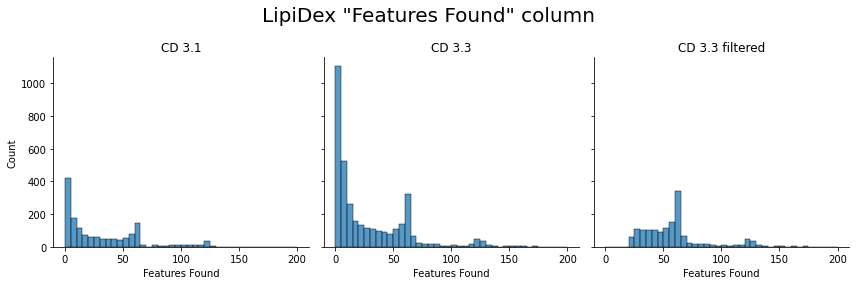

In [33]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, sharex=True, sharey=True)
fig.set_size_inches(12, 4)
sns.histplot(c31['Features Found'], binwidth=5, binrange=(0, 200), ax=ax1)
sns.histplot(c33['Features Found'], binwidth=5, binrange=(0, 200), ax=ax2)
sns.histplot(c3f['Features Found'], binwidth=5, binrange=(0, 200), ax=ax3)
ax1.set_title('CD 3.1')
ax2.set_title('CD 3.3')
ax3.set_title('CD 3.3 filtered')
sns.despine()
fig.suptitle('LipiDex "Features Found" column', fontsize=20)
plt.tight_layout()
# plt.savefig(r'..\reports\figures\1-0-1\feats_found_distrib.svg', bbox_inches='tight')
# plt.savefig(r'..\reports\figures\1-0-1\feats_found_distrib.png', bbox_inches='tight', dpi=300)

### Feature Blank Filtering

Text(0.5, 1.0, 'Ratio of (mean - blankmax) / mean')

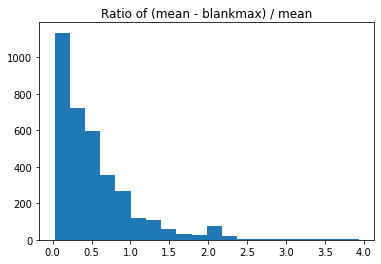

In [126]:
## What proportion of the maxes of all blank rows are more than double the mean of the rows?
## Should I use blank_cols max() or mean() for filtering? 
## Based on this, it seems that max() is OK, and it makes the most sense anyway
plt.hist((c33[blank_cols].max(axis=1) - c33[blank_cols].mean(axis=1)) / c33[blank_cols].mean(axis=1), bins=20);
plt.title('Ratio of (mean - blankmax) / mean')

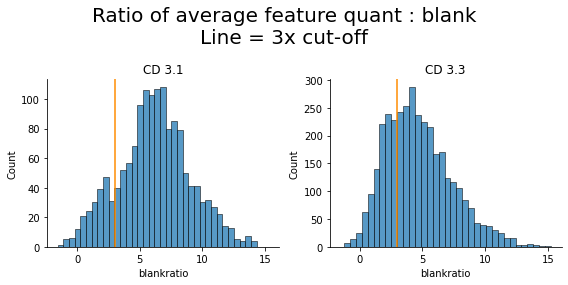

In [646]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharex=True)
fig.set_size_inches(8, 4)
sns.histplot(c31d['blankratio'], bins=35, ax=ax1)
sns.histplot(c33d['blankratio'], bins=35, ax=ax2)
ax1.set_title('CD 3.1')
ax2.set_title('CD 3.3')
ax1.axvline((3), color='darkorange')
ax2.axvline((3), color='darkorange')
sns.despine()
fig.suptitle('Ratio of average feature quant : blank\nLine = 3x cut-off', fontsize=20)
plt.tight_layout()

plt.savefig(r'..\reports\figures\1-0-1\blank_ratio.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\1-0-1\blank_ratio.png', bbox_inches='tight', dpi=300)

# plt.hist(np.log2(c31[data_cols].mean(axis=1) / c31[blank_cols].max(axis=1)), bins=35)
# plt.axvline(x=np.log2(3), color='darkorange')
# plt.title('Log2 feature Mean/feature Blank')
# plt.figure()
# plt.hist(np.log2(c33[data_cols].mean(axis=1) / c33[blank_cols].max(axis=1)), bins=35)
# plt.axvline(x=np.log2(3), color='darkorange')
# plt.title('Log2 feature Mean/feature Blank')

### Feature RSDs

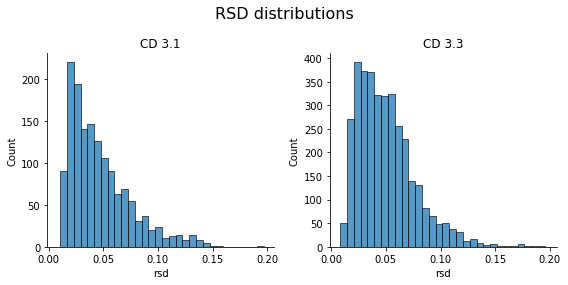

In [649]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=False, sharex=True)
fig.set_size_inches(8, 4)
sns.histplot(c31d['rsd'], bins=30, ax=ax1,)
sns.histplot(c33d['rsd'], bins=30, ax=ax2,)
ax1.set_title('CD 3.1')
ax2.set_title('CD 3.3')
fig.suptitle('RSD distributions', fontsize=16)
sns.despine()
plt.tight_layout()

plt.savefig(r'..\reports\figures\1-0-1\RSD_distrib.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\1-0-1\RSD_distrib.png', bbox_inches='tight', dpi=300)

### 2-D heatmap plot (or scatterplot) of x-axis=(feature average/blank) and y-axis=(feature RSD) with lines for 3x and 20% cutoffs

### Not a very informative plot

Text(0.5, 1.0, 'CD 3.3')

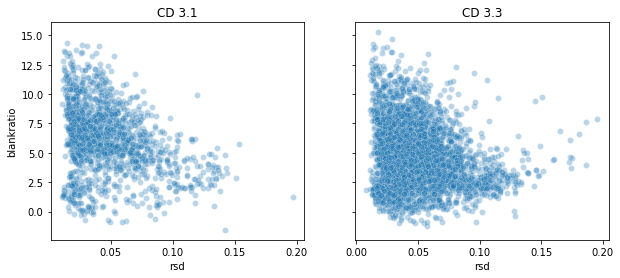

In [198]:
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
fig.set_size_inches(10, 4)
sns.scatterplot(x=c31d['rsd'], y=c31d['blankratio'], alpha=0.3, ax=ax1,)
sns.scatterplot(x=c33d['rsd'], y=c33d['blankratio'], alpha=0.3, ax=ax2,)
ax1.set_title('CD 3.1')
ax2.set_title('CD 3.3')

### Distribution of areas

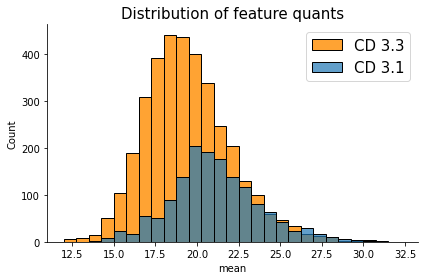

In [56]:
fig, ax1  = plt.subplots(ncols=1, sharey=True)
fig.set_size_inches(6, 4)

sns.histplot(c33d['mean'], ax=ax1, color='darkorange', alpha=0.8, binrange=(12, 32), binwidth=.75, label='CD 3.3')
sns.histplot(c31d['mean'], ax=ax1, binrange=(12, 32), binwidth=.75, alpha=0.7, label='CD 3.1')
plt.legend(fontsize=15)
ax1.set_title('Distribution of feature quants', fontsize=15)
# ax2.set_title('CD 3.3')
plt.tight_layout()
sns.despine()

plt.savefig(r'..\reports\figures\1-0-1\distrib_feat_quant.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\1-0-1\distrib_feat_quant.png', bbox_inches='tight', dpi=300)

### Distribution of ID quants CD 3.1 vs 3.3 

combined_col_name
1091_8_FBG     20210729_AJ_Toh_RatBloodGlucose_T1091M_2021032...
1091_9_FBG     20210729_AJ_Toh_RatBloodGlucose_T1091M_2021040...
1091_10_FBG    20210729_AJ_Toh_RatBloodGlucose_T1091M_2021041...
1093_8_FBG     20210729_AJ_Toh_RatBloodGlucose_T1093M_2021032...
1093_9_FBG     20210729_AJ_Toh_RatBloodGlucose_T1093M_2021040...
1093_10_FBG    20210729_AJ_Toh_RatBloodGlucose_T1093M_2021041...
1060_8_FBG     20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...
1060_9_FBG     20210729_AJ_Toh_RatBloodGlucose_T1060M_2021032...
1060_10_FBG    20210729_AJ_Toh_RatBloodGlucose_T1060M_2021040...
1062_8_FBG     20210729_AJ_Toh_RatBloodGlucose_T1062M_2021032...
1062_9_FBG     20210729_AJ_Toh_RatBloodGlucose_T1062M_2021032...
1062_10_FBG    20210729_AJ_Toh_RatBloodGlucose_T1062M_2021040...
1074_8_FBG     20210729_AJ_Toh_RatBloodGlucose_T1074M_2021032...
1074_9_FBG     20210729_AJ_Toh_RatBloodGlucose_T1074M_2021032...
1074_10_FBG    20210729_AJ_Toh_RatBloodGlucose_T1074M_2021040...
1092_8_

In [69]:
cd33fidmean

89      6.271500e+06
90      1.985024e+06
99      1.687031e+06
110     6.412063e+07
113     1.173405e+07
            ...     
1471    4.862299e+05
1474    3.727009e+06
1476    1.010249e+07
1477    1.759901e+06
1478    5.464861e+06
Length: 391, dtype: float64

In [66]:
sns.histplot(cd33fidmean, ax=ax1, color='darkorange', alpha=0.8, binrange=(12, 32), binwidth=.75, label='CD 3.3 IDs')


<AxesSubplot:title={'center':'Distribution of feature quants'}, ylabel='Count'>

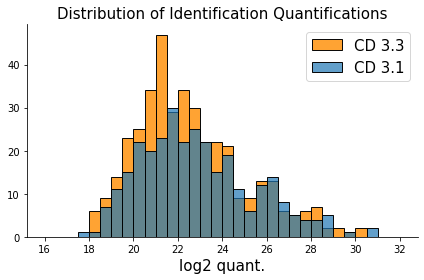

In [92]:
cd31fidmean = data.loc[(data['Proposed ID'] != 'unknown') & (data['Type'] == 'lipid'), data_cols].mean(axis=1)
cd33fidmean = np.log2(c3f.loc[c3f['Lipid Class'] != 'unknown', fg['fr_name']].mean(axis=1))
fig, ax1  = plt.subplots(ncols=1, sharey=True)
fig.set_size_inches(6, 4)

sns.histplot(cd33fidmean, ax=ax1, 
#              kde=True,
             color='darkorange', alpha=0.8, binrange=(16, 32), binwidth=0.5, label='CD 3.3')
sns.histplot(cd31fidmean, ax=ax1, 
#              kde=True,
             binrange=(16, 32), binwidth=0.5, alpha=0.7, label='CD 3.1')
plt.legend(fontsize=15)
plt.ylabel('', fontsize=15)
plt.xlabel('log2 quant.', fontsize=15)
ax1.set_title('Distribution of Identification Quantifications', fontsize=15)
# ax2.set_title('CD 3.3')
plt.tight_layout()
sns.despine()

plt.savefig(r'..\reports\figures\1-0-1\distrib_ID_quant.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\1-0-1\distrib_ID_quant.png', bbox_inches='tight', dpi=300)

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
89,0.887,619.28979,-,3.041931e+07,LysoPI 20:4,LysoPI,94,3410.391326,3282.806408,2.041498e+06,...,1.038038e+07,7.146372e+06,7.716256e+06,8.357273e+06,8.637660e+06,4.438829e+06,4.852754e+06,4186.017991,3795.907940,3317.264648
90,0.892,595.28979,-,1.064872e+07,LysoPI 18:2,LysoPI,38,3681.010550,3410.236749,1.978779e+05,...,4.459615e+06,6.396025e+05,2.533925e+06,7.479055e+05,3.600686e+06,4.906666e+05,2.192210e+06,4572.369519,3943.255600,3483.702156
99,0.933,370.29581,+,5.631332e+06,AC 14:1,AC,49,3960.202586,3546.440922,1.918701e+06,...,1.865319e+06,2.293876e+06,4.526380e+05,2.786997e+06,7.995275e+05,3.221783e+06,3.904302e+05,4202.085431,3843.255164,3864.913242
110,1.031,542.32428,+,1.275802e+08,LysoPC 20:5,LysoPC,40,6410.136087,3840.470360,1.613870e+07,...,1.017430e+08,5.612871e+07,5.982302e+07,7.094963e+07,8.272758e+07,5.775463e+07,4.715630e+07,4475.016961,4063.015359,3904.534464
113,1.045,468.30859,+,3.523855e+07,LysoPC 14:0,LysoPC,43,5983.425207,3584.817365,1.946313e+06,...,1.746893e+07,5.667405e+06,9.044859e+06,9.125325e+06,1.879201e+07,1.967163e+07,6.766082e+06,4177.123376,3706.324005,3644.616841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1471,19.139,984.89575,+,3.930095e+06,TG 18:2_18:1_24:1,TG,24,13109.344570,18475.210530,2.487873e+05,...,4.455810e+05,2.086491e+05,8.438053e+05,1.491902e+05,1.391520e+06,1.974327e+05,6.716086e+05,27221.349770,15079.197170,15850.552250
1474,19.171,932.86499,+,2.996361e+07,TG 56:2,TG,78,18565.662290,25013.353190,2.872971e+06,...,2.662101e+06,2.402360e+06,6.238021e+06,1.511454e+06,9.954991e+06,1.058031e+06,5.100009e+06,36854.640180,20415.533780,21459.861640
1476,19.215,906.84937,+,8.897676e+07,TG 54:1,TG,62,12092.640650,12502.362490,6.965709e+06,...,6.685992e+06,4.822509e+06,1.655427e+07,3.706839e+06,2.451166e+07,5.175460e+06,1.327253e+07,87179.954130,13847.309260,16867.181420
1477,19.222,958.87994,+,1.439327e+07,TG 18:2_18:1_22:0,TG,45,21769.034920,39829.989510,1.018773e+06,...,1.307265e+06,1.142641e+06,2.835159e+06,6.292183e+05,5.058947e+06,9.722471e+05,2.358212e+06,25706.802250,23938.088550,22535.837720


In [ ]:
fig, ax1  = plt.subplots(ncols=1, sharey=True)
fig.set_size_inches(6, 4)

sns.histplot(c33d['mean'], ax=ax1, color='darkorange', alpha=0.8, binrange=(12, 32), binwidth=.75, label='CD 3.3')
sns.histplot(c31d['mean'], ax=ax1, binrange=(12, 32), binwidth=.75, alpha=0.7, label='CD 3.1')
plt.legend(fontsize=15)
ax1.set_title('Distribution of feature quants', fontsize=15)
# ax2.set_title('CD 3.3')
plt.tight_layout()
sns.despine()

# plt.savefig(r'..\reports\figures\1-0-1\distrib_feat_quant.svg', bbox_inches='tight')
# plt.savefig(r'..\reports\figures\1-0-1\distrib_feat_quant.png', bbox_inches='tight', dpi=300)

### QC variance (all 3 QC files)

### Note that QC1 was the first sample run, without any pre-conditioning. It has a strangely low file size (78 MB vs 88-90 MB for rest)

Text(0, 0.5, 'RSD (%)')

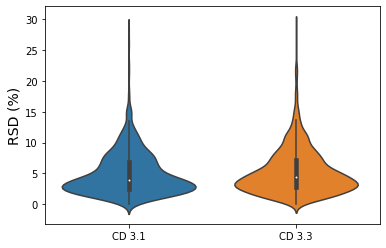

In [227]:
c31qc = c31d.loc[:, qc_cols]
c33qc = c33d.loc[:, qc_cols]
c31qc['rsd'] = c31qc.std(axis=1) / c31qc.mean(axis=1)
c33qc['rsd'] = c33qc.std(axis=1) / c33qc.mean(axis=1)
sns.violinplot(data=[c31qc['rsd']*100, c33qc['rsd']*100],  
               positions=[0, 0],
               orient='Vertical',
#                scale='count',
              )
plt.xticks(ticks=[0,1], labels=['CD 3.1', 'CD 3.3'])
plt.ylabel('RSD (%)', fontsize=14)
# sns.violinplot(, positions=2, orient='v')
plt.title('QC file RSDs')
plt.tight_layout()
sns.despine()

plt.savefig(r'..\reports\figures\1-0-1\distrib_feat_quant.svg', bbox_inches='tight')
plt.savefig(r'..\reports\figures\1-0-1\distrib_feat_quant.png', bbox_inches='tight', dpi=300)

In [229]:
c33qc.loc[c33qc['rsd'] > 0.075]

,20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC1.raw (F11),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC2.raw (F12),20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC3.raw (F13),rsd
2,11.055147,14.045264,15.836094,0.177012
3,10.291200,11.225605,15.072147,0.207766
5,17.176528,20.150148,21.825289,0.119408
7,19.022265,21.446774,22.776966,0.090302
8,22.448467,26.943383,27.068896,0.103273
...,...,...,...,...
3540,11.560153,16.550311,16.421588,0.191635
3541,10.467167,12.170133,10.926323,0.078755
3545,10.859640,14.977410,15.050417,0.176001
3546,19.304678,22.097628,22.177710,0.077200


<AxesSubplot:xlabel='rsd'>

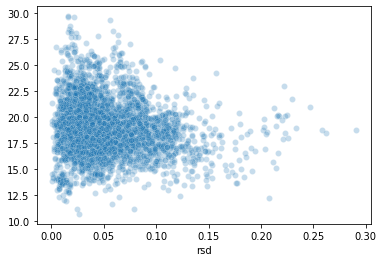

In [232]:
sns.scatterplot(x=c33qc['rsd'], y=c33qc[qc_cols].mean(axis=1), alpha=0.25)

### QC variance (all 3 files) on IDs

In [370]:
c31

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1101M_20210413_10wk_RBG.raw (F58),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210327_8wk_FBG.raw (F59),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210330_8wk_RBG.raw (F60),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67)
0,0.536,679.05463,+,2.408421e+07,NaN,unknown,49,6939.264074,7204.617522,1.145548e+07,...,1.771940e+07,1.647246e+07,1.366983e+07,1.568381e+07,1.290439e+07,1.353820e+07,1.360893e+07,8616.499626,7755.590041,7473.385618
1,0.537,641.10870,+,5.522238e+07,NaN,unknown,36,4957.644286,5147.221739,4.677270e+07,...,3.852845e+07,4.172903e+07,6.220326e+06,4.279894e+07,3.789880e+07,3.219858e+07,2.889174e+07,5992.201567,5261.096948,5307.954232
2,0.541,951.15973,-,3.238113e+07,NaN,unknown,10,31210.491250,6708.897037,1.625939e+07,...,1.569916e+07,1.912593e+07,1.216820e+07,2.036861e+07,1.952822e+07,1.953922e+07,1.543462e+07,9861.409380,94752.403070,72744.082630
3,0.542,329.03067,-,2.882770e+08,NaN,unknown,55,35414.640900,7612.606206,1.290199e+08,...,2.882770e+08,1.142664e+08,1.452781e+08,1.763549e+08,2.236196e+08,1.790767e+08,1.651242e+08,235854.330500,107515.844600,82542.935410
4,0.544,969.13147,-,1.697296e+07,NaN,unknown,14,36157.660320,7772.323038,1.089197e+07,...,6.578465e+06,8.023917e+06,4.351532e+06,1.132409e+07,1.040661e+07,8.373267e+06,9.059848e+06,240802.689200,109771.588600,84274.733400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1482,20.175,593.58716,+,3.296976e+06,NaN,unknown,19,13463.679470,14827.939600,1.801313e+06,...,2.390561e+05,1.291650e+06,2.886770e+05,8.545798e+05,6.331233e+05,1.647502e+06,2.088592e+05,15946.120300,15354.653040,15239.583030
1483,20.196,871.80945,+,2.595829e+06,NaN,unknown,6,11170.753640,11883.403090,1.053780e+06,...,7.948007e+04,8.523295e+05,8.869149e+04,4.884374e+05,1.233201e+05,1.052764e+06,4.261791e+04,12779.535150,11523.481420,11266.124030
1484,20.435,1003.93829,+,3.203813e+06,NaN,unknown,4,12695.823470,13819.097200,5.844701e+05,...,3.421911e+05,3.890957e+05,7.912981e+05,1.910285e+05,1.147269e+06,4.434897e+05,5.509051e+05,23229.657890,14761.180040,17844.172830
1485,20.452,1164.01404,+,3.204960e+06,NaN,unknown,2,13749.188890,14296.409340,1.669550e+04,...,2.521927e+05,2.039074e+04,7.236153e+05,3.054687e+04,1.097559e+06,2.851977e+04,5.293939e+05,24032.011160,15271.031760,18460.511230


### What proportion of Lipids have poly-unsaturations

In [547]:
fa = parse_lipid('TG 20:2')[-1]

In [598]:
serum['Identification'].unique()

array(['LysoPC 20:4', 'LysoPC 18:2', 'LysoPC 16:0', 'LysoPC 22:6',
       'LysoPC 20:3', 'LysoPC 18:1', 'PC[OH] OH-41:11', 'SHexCer d34:1',
       'PC 42:11', 'PI 16:1_16:0', 'PI 16:0_20:4',
       'Alkenyl-DG P-16:0_20:5', 'PC 34:5', 'PC 40:9', 'PI 16:0_18:2',
       'Alkenyl-DG P-18:1_20:5', 'PI 18:1_20:4', 'SM d32:1', 'PI 36:3',
       'Alkanyl-DG O-36:5', 'PC 14:0_22:6', 'SM d34:2', 'PC 42:10',
       'PC 18:3_18:2', 'PC 35:5', 'PC 18:2_20:5', 'PI 40:6',
       'PC 14:0_20:4', 'PC 30:1', 'SM d36:3', 'PC 20:4_20:4',
       'PI 16:0_16:0', 'PC[OH] OH-34:2', 'PC 32:2', 'SM d33:1', 'PC 37:6',
       'PI 34:1', 'Alkenyl-DG P-18:0_20:5', 'PI 18:0_22:5',
       'PI 18:0_20:4', 'PC 18:2_20:4', 'PC 16:0_20:5',
       'Alkanyl-DG O-34:3', 'Alkanyl-DG O-36:4', 'PI 36:2',
       'PE-NMe2 34:3', 'PC 34:3', 'PC 18:2_18:2', 'PC 15:0_20:4',
       'PE 16:0_20:5', 'PI 18:0_20:3', 'PC 16:0_22:6', 'PC 15:0_18:2',
       'SM d34:1', 'PC 37:5', 'PC 40:7', 'Plasmanyl-PC O-36:5', 'PC 30:0',
       'Plasm

In [595]:
def is_polyunsat(ID):
#     print(ID)
    if type(ID) == float or ID == 'unknown' or ID == 'Unidentified':
        return False
    cls, label, carbons, unsat, fas = parse_lipid(ID)
    
    # 1 FA case
    if cls in ['AC', 'CE'] or 'Lyso' in cls:
        if unsat > 1:
            return True
        
    # 1 FA and 1 unsaturated backbone
    elif 'Cer' in cls or cls in ['SM', 'Alkenyl-DG', 'Alkanyl-DG'] or 'lasm' in cls:
        if unsat > 2:
            return True
    
    # 2 FA case:
    elif cls in ['PC', 'PI', 'PE', 'PS', 'PG', 'PC[OH]', 'PE-NMe2']:
        if unsat > 2:
            return True
        elif len(fas) > 1:  # check if not sum composition
            for fa in fas:
                if fa[1] > 1:
                    return True
    
    # 3 FA case
    elif cls == 'TG':
        if unsat > 3:
            return True
        elif len(fas) > 1:  # check if not sum composition
            for fa in fas:
                if fa[1] > 1:
                    return True 
    else:
        raise ValueError('Lipid class not handled')
    return False


for i, row in c33.loc[c33['Identification'].notna(), ['Identification']].iterrows():
    print(is_polyunsat(row['Identification']))

True
True
False
False
True
False
False
True
True
True
False
True
False
False
False
True
False
True
False
True
True
True
True
False
True
False
False
False
False
False
False
False
True
False
True
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
False
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
True
True
False
True
True
True
True
True
True
True
True
False
False
True
False
True
True
True
False
True
True
True
True
False
True
True
True
True
True
True
True
True
False
True
True
True
True
True
False
False
True
False
True
True
False
True
True
True
True
True
True
False
True
True
True
True
True
False
True
True
True
True
True
True
True
True
False
True
False
True
True
False
True
True
True
True
True
True
True
True
False
True
True
False
False
True
True
Tru

In [572]:
c33['polyunsat'] = c33['Identification'].apply(lambda x: is_polyunsat(x))
c33['fa_carbons'] = c33.loc[c33['Identification'].notna(), 'Identification'].apply(lambda x: parse_lipid(x)[2])
c33['fa_unsats'] = c33.loc[c33['Identification'].notna(), 'Identification'].apply(lambda x: parse_lipid(x)[3])

In [573]:
c33.loc[(c33['Identification'].notna()) & c33['polyunsat']].iloc[:50]

,Retention Time (min),Quant Ion,Polarity,Area (max),Identification,Lipid Class,Features Found,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw (F3),...,20210729_AJ_Toh_RatBloodGlucose_T1102M_20210402_9wk_FBG.raw (F61),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210406_9wk_RBG.raw (F62),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210410_10wk_FBG.raw (F63),20210729_AJ_Toh_RatBloodGlucose_T1102M_20210413_10wk_RBG.raw (F64),20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67),polyunsat,fa_carbons,fa_unsats
225,0.887,619.28979,-,3.041931e+07,LysoPI 20:4,LysoPI,94,3410.391326,3282.806408,2.041498e+06,...,8.357273e+06,8.637660e+06,4.438829e+06,4.852754e+06,4186.017991,3795.907940,3317.264648,True,20.0,4.0
226,0.892,595.28979,-,1.064872e+07,LysoPI 18:2,LysoPI,38,3681.010550,3410.236749,1.978779e+05,...,7.479055e+05,3.600686e+06,4.906666e+05,2.192210e+06,4572.369519,3943.255600,3483.702156,True,18.0,2.0
280,1.031,542.32428,+,1.275802e+08,LysoPC 20:5,LysoPC,40,6410.136087,3840.470360,1.613870e+07,...,7.094963e+07,8.272758e+07,5.775463e+07,4.715630e+07,4475.016961,4063.015359,3904.534464,True,20.0,5.0
302,1.062,520.33997,+,9.292611e+08,LysoPC 18:2,LysoPC,123,39126.077810,2368.293204,4.005910e+07,...,2.190781e+08,5.325401e+08,1.745102e+08,2.458092e+08,2759.597462,2448.566010,2407.799454,True,18.0,2.0
303,1.062,568.33960,+,1.898476e+08,LysoPC 22:6,LysoPC,67,5866.546056,2311.414233,2.756562e+07,...,8.925618e+07,6.811002e+07,6.366614e+07,3.192004e+07,2693.320590,2389.759138,2349.971667,True,22.0,6.0
305,1.064,544.33960,+,1.395434e+08,LysoPC 20:4,LysoPC,56,16284.753180,2500.640096,1.341537e+07,...,7.998132e+07,6.216438e+07,5.868135e+07,2.687127e+07,2913.811537,2585.398772,2542.354066,True,20.0,4.0
313,1.075,518.32239,+,7.426368e+07,LysoPC 18:3,LysoPC,11,25313.158510,5142.623641,6.827011e+06,...,4.834371e+07,3.080849e+07,1.595928e+07,1.777741e+07,6931.568667,5333.840879,5245.698851,True,18.0,3.0
349,1.290,568.33960,+,1.403690e+08,LysoPC 22:6,LysoPC,62,7878.069754,7495.154688,4.083247e+07,...,3.580919e+07,2.574803e+07,4.235975e+07,1.424347e+07,8741.776697,8046.001610,7642.708328,True,22.0,6.0
354,1.312,500.27866,-,1.864537e+06,LysoPE 20:4,LysoPE,54,8258.173963,7518.306227,3.195573e+05,...,7.162626e+05,6.880662e+05,8.917138e+05,3.409502e+05,10005.643760,8906.853535,8419.741858,True,20.0,4.0
361,1.334,544.33984,+,1.420180e+08,LysoPC 20:4,LysoPC,124,9301.157948,8898.777016,3.083068e+07,...,4.677275e+07,3.685116e+07,6.453416e+07,1.940708e+07,9828.671167,9289.022667,9091.706971,True,20.0,4.0


### What is the ratio of FA carbons : FA unsaturations in our IDs? 

Text(0.19, 40, 'more unsaturated')

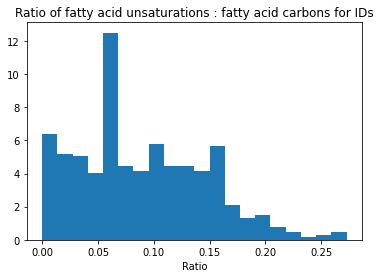

In [626]:
c33_unsat_per_carbon = c33.loc[(c33['Identification'].notna()), 'fa_unsats'] / \
                       c33.loc[(c33['Identification'].notna()), 'fa_carbons']

plt.hist(c33_unsat_per_carbon, bins=20, density=True)
plt.title('Ratio of fatty acid unsaturations : fatty acid carbons for IDs')
plt.xlabel('Ratio')
plt.annotate('more unsaturated', (0.19, 40))

In [623]:
serum = pd.read_csv(r'..\data\processed\Yuchen_2019_Serum_Lipidomics_Final_Results.csv')
serum = serum.loc[serum['Identification'].notna()]
serum['Lipid Class'].unique()
serum['polyunsat'] = serum['Identification'].apply(lambda x: is_polyunsat(x))
serum['fa_carbons'] = serum.loc[serum['Identification'].notna(), 
                                              'Identification'].apply(lambda x: parse_lipid(x)[2])
serum['fa_unsats'] = serum.loc[serum['Identification'].notna(), 
                           'Identification'].apply(lambda x: parse_lipid(x)[3])

Text(0.5, 0, 'Ratio')

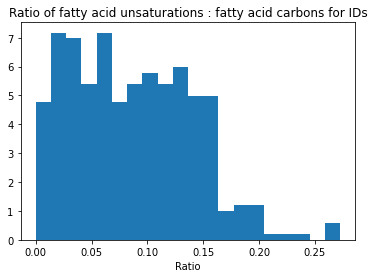

In [624]:
serum_unsat_per_carbon = serum.loc[:, 'fa_unsats'] / serum.loc[:, 'fa_carbons']
plt.hist(serum_unsat_per_carbon, bins=20, density=True)
plt.title('Ratio of fatty acid unsaturations : fatty acid carbons for IDs')
plt.xlabel('Ratio')
# plt.annotate('more unsaturated', (0.19, 40))

### Are these two distributions of unsaturation/carbons statistically different? 

In [625]:
from scipy.stats import mannwhitneyu
mannwhitneyu(c33_unsat_per_carbon, serum_unsat_per_carbon)

MannwhitneyuResult(statistic=88877.5, pvalue=0.30562477066907323)